<a href="https://colab.research.google.com/github/AndreaCorrado00/Brain-Tumor-classification-with-deep-learning/blob/main/Brain_tumor_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor MRI Classification**
*Final project of the course of DeepLearning*

*Master Degree in Bioengineering*

*Andrea Corrado*

# Introduction

The aim of this project is find out a way to classify multi-instances of brain tumors. Following a transfer learning strategy, a CNN based on EffNetB1 frame was trained on an augmented dataset. The augmentation of the dataset ensure the robustness of the model.

Here is a brief description of the types of tumors we are dealing with, along
with information on how to distinguish them.





**Meningioma:**

Description: Meningiomas are typically slow-growing tumors that arise from the meninges, the layers of tissue covering the brain and spinal cord. They are often benign, but some may exhibit more aggressive behavior.

Location: Meningiomas can occur anywhere along the meninges, but they are commonly found near the surface of the brain.

Imaging Characteristics: On imaging, meningiomas often appear as well-defined masses with a dural tail (a tail-like extension along the dura mater). They are usually enhancing on contrast-enhanced MRI.


**Glioma:**

Description: Gliomas are tumors that arise from the glial cells in the brain or spinal cord. They can be either benign or malignant and are further classified into different types based on the specific glial cell involved (e.g., astrocytomas, oligodendrogliomas, glioblastomas).

Location: Gliomas can occur anywhere in the brain and can infiltrate surrounding tissue. Their location and invasiveness vary depending on the specific type and grade of glioma.

Imaging Characteristics: Gliomas may appear infiltrative on imaging, with less defined borders compared to meningiomas. The appearance varies based on the type and grade of the glioma.

**Pituitary Tumor:**

Description: Pituitary tumors are tumors that arise from the pituitary gland, a small gland at the base of the brain that regulates hormone production.

Location: The pituitary gland is located at the base of the brain, and tumors arising from it can affect hormonal regulation and may compress nearby structures.

Imaging Characteristics: Pituitary tumors can be visualized on MRI and may exhibit different characteristics based on their type (e.g., non-functioning adenomas, prolactinomas). They may cause enlargement of the sella turcica, the bony structure housing the pituitary gland.


---

# Importing Libraries




In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings

# libraries to interface with the os
from os.path import join
from glob import glob

# Keras
from tensorflow import keras
from tensorflow.keras import layers



### Using GPU to train the model
Here we connect our ambiet to a GPU in order to train our model quickly.

In [ ]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print(f"Found {len(gpus)} GPU")
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
  print('no Gpu')

Found 1 GPU


---

### Color

 This part of the code defines three lists of colors, each list contains a range of color hex codes.  This is helpful for visualizing and choosing color schemes for data visualizations or plots.

In [ ]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

# To show colors
#sns.palplot(colors_dark)
#sns.palplot(colors_green)
#sns.palplot(colors_red)

---

# Data Preparation

This part of the code prepare the image data and corresponding labels for training and testing a brain tumor classification model using TensorFlow/Keras.  
It involves:

*   Defining the four classification categories
*  Loading images from the directories into a Python list
*   Resizing data images according to the net used requirements
*   Converting data images into numpy arrays
*   Dividing the entire dataset into training and test sets using a 90-20% split
*   Performing One Hot Encoding on the labels after converting them into numerical values for machine learning model training.





## Data Loading

### Reading data from Drive

In [ ]:
# Mounthing google drive to access data.
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/MyDrive"
# Be sure to have a shortcutof the .zip folder in your drive main page.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
# Reading file .zip
from zipfile import ZipFile

with ZipFile("Brain-Tumor-Classification-DataSet-master.zip", "r") as f:
    f.extractall("/content/")

# Now the code loads the data from the subfolders of the zip archive
# Reading training
data_folder_train = "/content/Brain-Tumor-Classification-DataSet-master/Training"
train_classes = sorted([f for f in os.listdir(data_folder_train) if not f.startswith('.')])
# Reading Testing
data_folder_test = "/content/Brain-Tumor-Classification-DataSet-master/Testing"
test_classes = sorted([f for f in os.listdir(data_folder_test) if not f.startswith('.')])


# train folder composition
imgs = {c: glob(join(data_folder_train, c, "*")) for c in train_classes}
print('Folder "Training" has size-by-classes:')
for key in imgs.keys():
  print("- {} class has {} samples".format(key, len(imgs[key])))

# test folder composition
print('\n')
imgs_test = {c: glob(join(data_folder_test, c, "*")) for c in test_classes}
print('Folder "Testing" has size-by-classes:')
for key in imgs_test.keys():
  print("- {} class has {} samples".format(key, len(imgs_test[key])))


labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']


Folder "Training" has size-by-classes:
- glioma_tumor class has 826 samples
- meningioma_tumor class has 822 samples
- no_tumor class has 395 samples
- pituitary_tumor class has 827 samples


Folder "Testing" has size-by-classes:
- glioma_tumor class has 100 samples
- meningioma_tumor class has 115 samples
- no_tumor class has 105 samples
- pituitary_tumor class has 74 samples


## Building the Training and Test set




In [ ]:
X_train = []
y_train = []

image_size = 	240 #Coerent with the architepture of  EffNetB0
for key in imgs.keys():
    for j in range(1,len(imgs[key])):
        img = cv2.imread(imgs[key][j])
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(key)

for key in imgs_test.keys():
    for j in range(1,len(imgs_test[key])):
        img = cv2.imread(imgs_test[key][j])
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(key)

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train.shape)
print(y_train.shape)

(3256, 240, 240, 3)
(3256,)


Use the folliwing code to show an example of images of the dateset



glioma_tumor
Image dtype = uint8
Min pixel value = 0
Max pixel value = 242
Shape = (240, 240, 3)


no_tumor
Image dtype = uint8
Min pixel value = 0
Max pixel value = 255
Shape = (240, 240, 3)


meningioma_tumor
Image dtype = uint8
Min pixel value = 0
Max pixel value = 254
Shape = (240, 240, 3)


pituitary_tumor
Image dtype = uint8
Min pixel value = 0
Max pixel value = 252
Shape = (240, 240, 3)


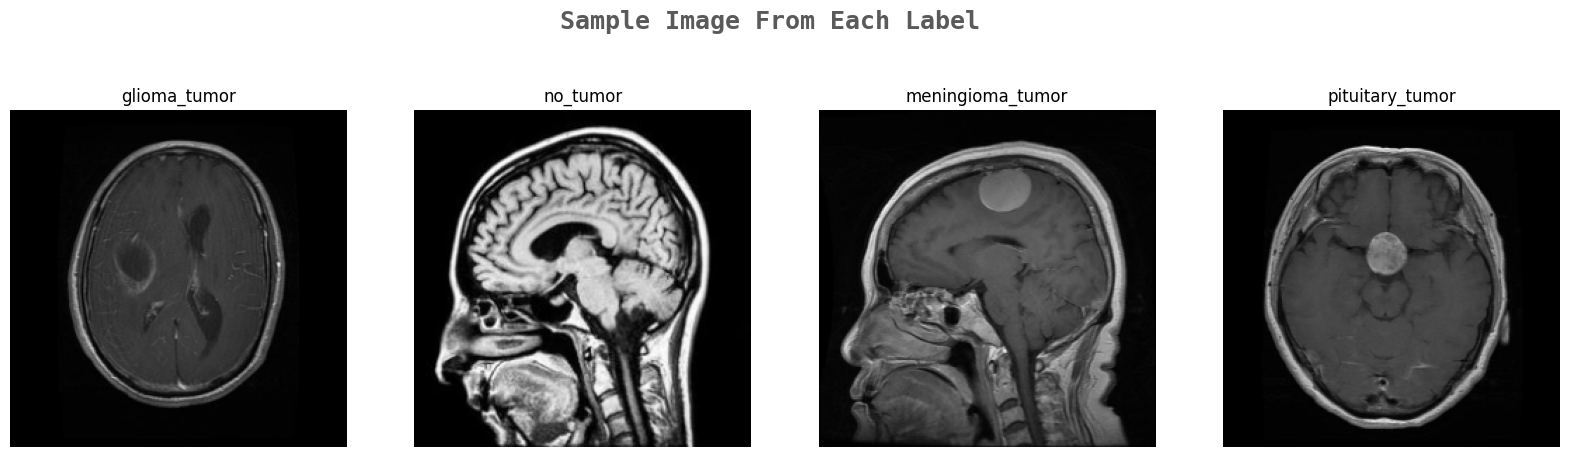

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)

# Quick excursus of the dataset
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            print('\n')
            print(i)
            print("Image dtype ="    , X_train[j].dtype)
            print("Min pixel value =", X_train[j].min())
            print("Max pixel value =", X_train[j].max())
            print("Shape =", X_train[j].shape)
            k+=1
            break
        j+=1

### Dividing the dataset into **Training** and **Testing** sets.

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)

print("Train set has size {}".format(X_train.shape))
print("Test set has size {}".format(X_test.shape))


# Check that the split accurately mirrors the actual distribution of data
unique_labels_train, counts_train = np.unique(y_train, return_counts=True)
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)

print("\nTraining set size-by-classes:")
for label, count in zip(unique_labels_train, counts_train):
    print(f"- {label} class has {count} samples")

print("\nTesting set size-by-classes:")
for label, count in zip(unique_labels_test, counts_test):
    print(f"- {label} class has {count} samples")



Train set has size (2604, 240, 240, 3)
Test set has size (652, 240, 240, 3)

Training set size-by-classes:
- glioma_tumor class has 734 samples
- meningioma_tumor class has 749 samples
- no_tumor class has 396 samples
- pituitary_tumor class has 725 samples

Testing set size-by-classes:
- glioma_tumor class has 190 samples
- meningioma_tumor class has 186 samples
- no_tumor class has 102 samples
- pituitary_tumor class has 174 samples


Performing **One Hot Encoding** on the labels after converting it into numerical values:

---

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

# The model used: fine tuning of a EfficientNet

Here the model is built. Based on EffNetB1 the model starts with a data aumentation pipeline built considering the real-life possible functioning of the net. Then it followos the transfer learning of EffNetB1 backbone and finally some layers are added to ensure che 4-class classification. To avoid the risk of overfitting, final layers implement two layer of dropout.






###  Preprocessing and Data Augmentation

EffNetB1 performs autonomously preprocessing on input images, so that the only pipepline necessary is the one of data augmentation. In this case the transformations considered are linked directly with the real life usage of the model, into which there aren't images strongly deformed, flipped and so on. So, in this context, data augmentation is important to make the model robust but not to show to the net some very different situations.



> **Data augmentation**: the following operations were performed to make the model more robust



1. **Rotation and Reflection:** Apply random rotations and reflections to improve image diversity.

2. **Zoom and Scaling:** Vary the scale of the images to improve the generalisation of the pattern.

3.  **Contrast Adjustment:** Change contrast to make the model more robust to changes in illumination.

4. **Added Noise:** Add noise to images to improve model robustness.




In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip(),
        layers.RandomZoom(height_factor=(-0.4, 0.4), width_factor=(-0.4, 0.4)),
        layers.RandomContrast(factor=0.2),
        layers.GaussianNoise(stddev=0.5),

    ]
)

### Model definition

In [ ]:
def transfer_learning_network(input_shape, num_class=4, freeze_backbone=True, augment=True):
    input_layer = layers.Input(input_shape)

    # DATA AUGMENTATION
    if augment:
      x = data_augmentation(input_layer)
    else:
      x=input_layer

    # Model definition
    # Backbone
    backbone=EfficientNetB1(weights='imagenet', include_top=False, input_tensor= x)



    # Freezing or not freezing the backbone based on the 'freeze_backbone' parameter
    backbone.trainable = not freeze_backbone

    x = backbone.output
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.Dense(num_class, activation='softmax')(x)

    model = keras.Model(inputs=input_layer, outputs=x)

    return model

In [ ]:
model=transfer_learning_network(input_shape=(image_size,image_size,3), num_class=4, freeze_backbone=False, augment=True)
# If freeze_backbone:
  # is True: the backbone is freezed and the training is a real transfer learning
  # is False: the backbone is trainable and we are making fine tuning

# Showing the model
show_summary=False
show_model_plot=False
if show_summary:
  model.summary()
if show_model_plot:
  keras.utils.plot_model(model, show_shapes=True)



### Compile the model
Originally, the only metric used to define the cost function was accuracy. We decided to also use the F1-score, a metric that is widely used especially when dealing with multi-class problems exhibiting class imbalances.

In [ ]:

metrics = ["accuracy", keras.metrics.F1Score(name='f1_score', average='macro')] #Perhcé se uso keras.metrics.Accuracy() va tutto in vacca?

model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= metrics)

### Control of the training

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')

checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 3, min_delta = 0.005, mode='max', verbose=1)

earlystop = keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=15, restore_best_weights=True, verbose=1, mode='max')


---

# Training The Model

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.10, epochs =50, verbose=1, batch_size=64,
                   callbacks=[tensorboard, checkpoint,reduce_lr,earlystop])

Epoch 1/50
37/37 [==============================] - ETA: 0s - loss: 0.6030 - accuracy: 0.7700 - f1_score: 0.7677
Epoch 1: val_accuracy improved from -inf to 0.77778, saving model to effnet.h5
37/37 [==============================] - 83s 989ms/step - loss: 0.6030 - accuracy: 0.7700 - f1_score: 0.7677 - val_loss: 0.9240 - val_accuracy: 0.7778 - val_f1_score: 0.7610 - lr: 0.0010
Epoch 2/50
37/37 [==============================] - ETA: 0s - loss: 0.2657 - accuracy: 0.9057 - f1_score: 0.9072
Epoch 2: val_accuracy improved from 0.77778 to 0.80843, saving model to effnet.h5
37/37 [==============================] - 34s 930ms/step - loss: 0.2657 - accuracy: 0.9057 - f1_score: 0.9072 - val_loss: 0.8776 - val_accuracy: 0.8084 - val_f1_score: 0.7815 - lr: 0.0010
Epoch 3/50
37/37 [==============================] - ETA: 0s - loss: 0.1984 - accuracy: 0.9317 - f1_score: 0.9332
Epoch 3: val_accuracy improved from 0.80843 to 0.84674, saving model to effnet.h5
37/37 [==============================] - 33s

# Performances of the model

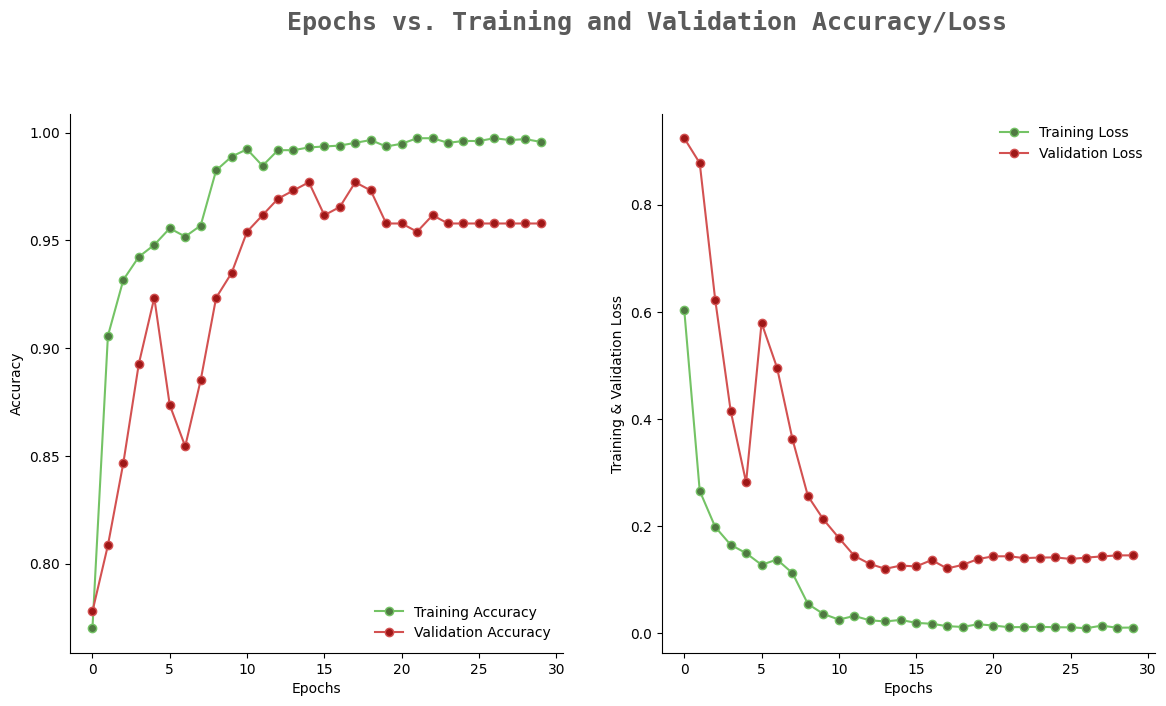

In [ ]:
filterwarnings('ignore')
num_epochs = len(history.history['accuracy'])

epochs = [i for i in range(num_epochs)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

---

### Prediction


The following lines of code make predictions using the trained model, extract the predicted class indices, and prepare the true class indices for the test set, facilitating the evaluation of model performance.

More specifically:


*   Use the trained model to predict outcomes on the test set and store the prediction in the variable "pred"
*   Apply the NumPy function argmax along axis 1 to the prediction array (pred). It converts the predicted probability distribution for each sample into the index of the class with the highest probability, effectively obtaining the predicted class indices.
*  Apply argmax to the ground truth labels (y_test) along axis 1. It converts one-hot encoded labels into class indices, obtaining the true class indices for the test set.





In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

21/21 [==============================] - 2s 86ms/step


---

### Evaluation



The code generates a heatmap of the confusion matrix based on the true class indices ‘y_test_new’ and the predicted class indices ‘pred’: the image represents how well the model is performing in terms of classification for each class, highlighting areas where misclassification may occur.

Here: <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       190
           1       0.96      0.98      0.97       102
           2       0.96      0.96      0.96       186
           3       0.98      1.00      0.99       174

    accuracy                           0.97       652
   macro avg       0.97      0.97      0.97       652
weighted avg       0.97      0.97      0.97       652



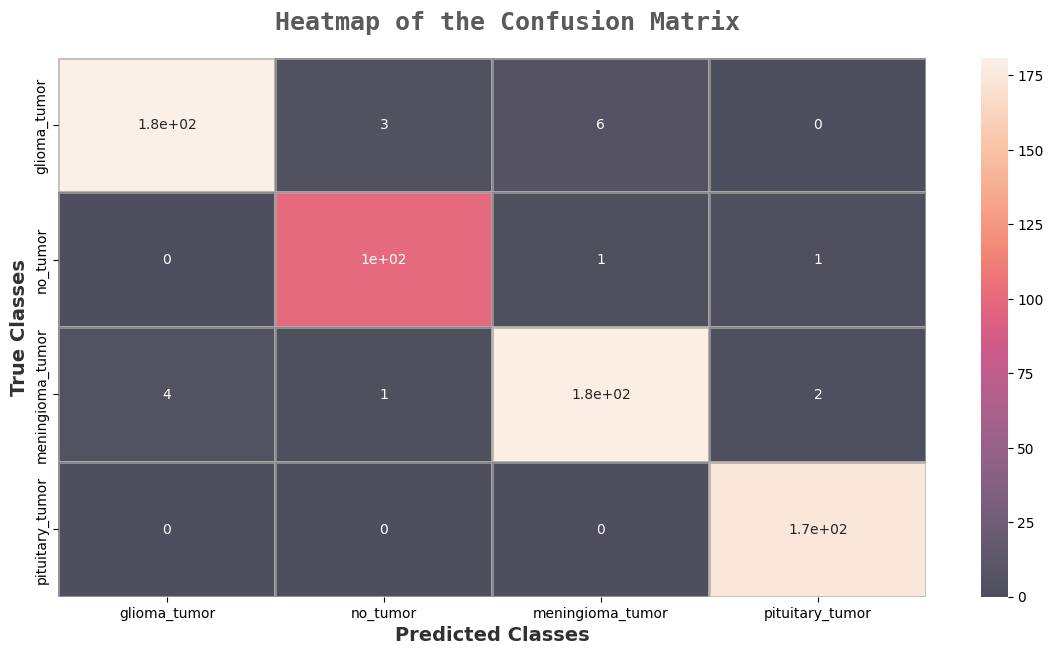

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_true=y_test_new,y_pred=pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           alpha=0.7,linewidths=2,linecolor=colors_dark[3])
# Adding labels to axes
ax.set_xlabel("Predicted Classes", fontsize=14, fontweight='bold', color=colors_dark[1])
ax.set_ylabel("True Classes", fontsize=14, fontweight='bold', color=colors_dark[1])

fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()



---

# Conclusion

The aim of this project was trying to figure out a way to predict and diagnose 3 types of tumors: glioma, meningioma, pituritary tumor compared with the healthy class.

Because of the limited number of samples in the dataset a strategy of data augmentation combined with transfer learning was used to solve the problem, leading to encouraging results.

In the end, the model was able to predict with an high accuracy the classes of tumors, but there where still some errors of classification which suggest a possibile overlappig of informations between tumors. Because of that a clinician must confirm the diagnosis and assess the goodness of the algorithm prediction. Future improvements could be assessing the tlevel of certainty with which a prediction is made by the model, helping the expert to decide the grade of trust on the results.


---

### <center>Thank You!